# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

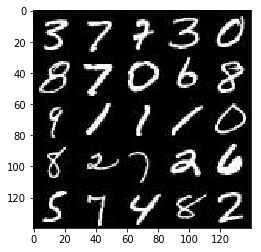

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

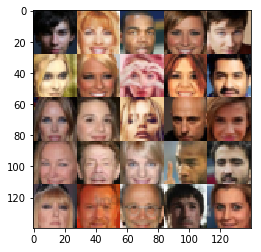

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    # input to our discriminator
    input_real = tf.placeholder(dtype=tf.float32, 
                                shape=(None,image_width, image_height, image_channels), name='input_real')
    
    # input to our generator network
    input_z = tf.placeholder(dtype=tf.float32, 
                             shape=(None, z_dim), name='input_z')
    
    # learning rate placeholder we will use later
    learning_rate =  tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')
    
    return input_real, input_z, learning_rate
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    # we build a convolutional network with 3 conv layers, increasing gradually the depth from 64 to 128 to 256
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # leaky relu :
        leak_factor = 0.15
        leaky_relu = lambda x: tf.maximum(leak_factor * x, x)
        
        layer1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        layer1 = leaky_relu(layer1)
        
        layer2 = tf.layers.conv2d(inputs=layer1, filters=128, kernel_size=5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2)
        
        layer3 = tf.layers.conv2d(inputs=layer2, filters=256, kernel_size=5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3)
        
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        leak_factor = 0.15
        leaky_relu = lambda x: tf.maximum(leak_factor * x, x)
        
        
        # first - dense layer from input z, then reshape to increase depth
        layer1 = tf.layers.dense(inputs=z, units=2*2*512) # dense layer 2048
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1)
    
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, 2, 'valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2)
    
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, 2, 'same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3)
    
        # deconvolution
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z, out_channel_dim, True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    
    # express the 2 components of the discriminator loss :
    # similar approach as in the previous lessons : sigmoid cross entropy with logits
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, 
                                                labels=tf.ones_like(discriminator_model_real)))
    
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    # generator loss : sigmoid 
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # name trainable variables
    trainable_variables = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_variables if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_variables if var.name.startswith('generator')]
    
    discriminator_train_optimizer = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
    
    # collect all ops for which the generator should be optimized and update it then
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(generator_updates):
        generator_train_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=generator_vars)
        
    return discriminator_train_optimizer, generator_train_optimizer



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # get the tuple of inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    
    print("input_z :: ",type(input_z))
    print("input_z shape :: ",np.shape(input_z))
    print("z_dim :: ",z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        t0 = time.clock()
        
        # iterate over epoch_count
        for epoch_i in range(epoch_count):
            step = 0

            # batch through the mnist images
            for batch_images in get_batches(batch_size):
                step +=1
                batch_images *= 2
                
                # random generator input 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if step % 30 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {} of {}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(step)," elapsed time - {:.2f}s ".format(time.clock() - t0),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show images 
                if step % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

input_z ::  <class 'tensorflow.python.framework.ops.Tensor'>
input_z shape ::  (?, 128)
z_dim ::  128
Epoch 1 of 2... Batch 30...  time spent - 5.19  Discriminator Loss: 0.3367... Generator Loss: 14.8559
Epoch 1 of 2... Batch 60...  time spent - 10.19  Discriminator Loss: 0.4538... Generator Loss: 2.1643
Epoch 1 of 2... Batch 90...  time spent - 15.24  Discriminator Loss: 0.2471... Generator Loss: 2.5420


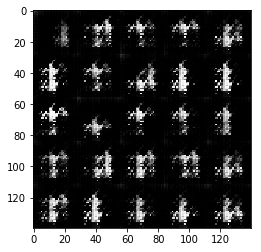

Epoch 1 of 2... Batch 120...  time spent - 21.09  Discriminator Loss: 0.1791... Generator Loss: 3.6206
Epoch 1 of 2... Batch 150...  time spent - 26.14  Discriminator Loss: 0.5949... Generator Loss: 3.5482
Epoch 1 of 2... Batch 180...  time spent - 31.17  Discriminator Loss: 2.5216... Generator Loss: 12.2912


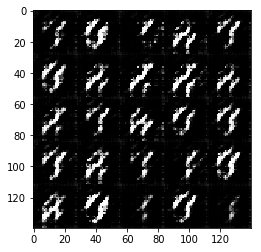

Epoch 1 of 2... Batch 210...  time spent - 37.22  Discriminator Loss: 0.3696... Generator Loss: 2.1448
Epoch 1 of 2... Batch 240...  time spent - 42.30  Discriminator Loss: 0.2021... Generator Loss: 3.5242
Epoch 1 of 2... Batch 270...  time spent - 47.31  Discriminator Loss: 0.3096... Generator Loss: 3.2696
Epoch 1 of 2... Batch 300...  time spent - 52.36  Discriminator Loss: 0.0838... Generator Loss: 3.3274


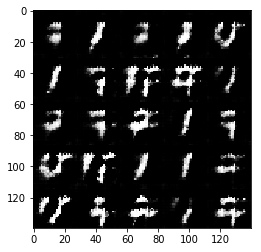

Epoch 1 of 2... Batch 330...  time spent - 58.24  Discriminator Loss: 0.8880... Generator Loss: 1.1872
Epoch 1 of 2... Batch 360...  time spent - 63.25  Discriminator Loss: 0.3466... Generator Loss: 2.4470
Epoch 1 of 2... Batch 390...  time spent - 68.27  Discriminator Loss: 0.4506... Generator Loss: 2.2607


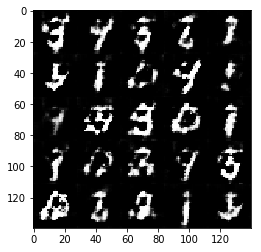

Epoch 1 of 2... Batch 420...  time spent - 74.14  Discriminator Loss: 1.1377... Generator Loss: 6.7654
Epoch 1 of 2... Batch 450...  time spent - 79.18  Discriminator Loss: 0.5156... Generator Loss: 2.5023
Epoch 2 of 2... Batch 30...  time spent - 87.13  Discriminator Loss: 0.6156... Generator Loss: 1.4751
Epoch 2 of 2... Batch 60...  time spent - 92.15  Discriminator Loss: 0.7265... Generator Loss: 1.4070
Epoch 2 of 2... Batch 90...  time spent - 97.16  Discriminator Loss: 0.6475... Generator Loss: 1.4914


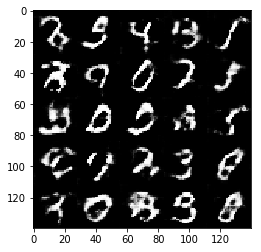

Epoch 2 of 2... Batch 120...  time spent - 103.03  Discriminator Loss: 0.8521... Generator Loss: 0.9418
Epoch 2 of 2... Batch 150...  time spent - 108.06  Discriminator Loss: 0.7146... Generator Loss: 1.1290
Epoch 2 of 2... Batch 180...  time spent - 113.07  Discriminator Loss: 0.7733... Generator Loss: 2.2004


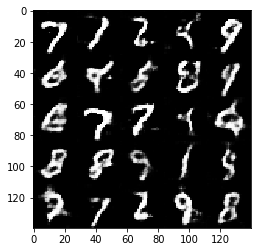

Epoch 2 of 2... Batch 210...  time spent - 118.92  Discriminator Loss: 0.7718... Generator Loss: 1.8150
Epoch 2 of 2... Batch 240...  time spent - 123.95  Discriminator Loss: 0.7636... Generator Loss: 1.2548


In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input_z ::  <class 'tensorflow.python.framework.ops.Tensor'>
input_z shape ::  (?, 50)
z_dim ::  50
Epoch 1 of 3... Batch 30...  elapsed time - 8.27s  Discriminator Loss: 0.5614... Generator Loss: 1.4017
Epoch 1 of 3... Batch 60...  elapsed time - 16.26s  Discriminator Loss: 0.3662... Generator Loss: 1.9039
Epoch 1 of 3... Batch 90...  elapsed time - 24.26s  Discriminator Loss: 0.2187... Generator Loss: 2.5780


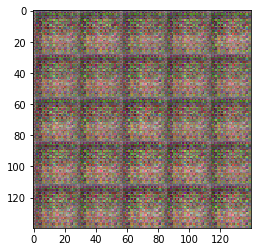

Epoch 1 of 3... Batch 120...  elapsed time - 33.09s  Discriminator Loss: 0.3096... Generator Loss: 2.4133
Epoch 1 of 3... Batch 150...  elapsed time - 41.06s  Discriminator Loss: 0.2497... Generator Loss: 2.4374
Epoch 1 of 3... Batch 180...  elapsed time - 49.02s  Discriminator Loss: 0.1985... Generator Loss: 4.3649


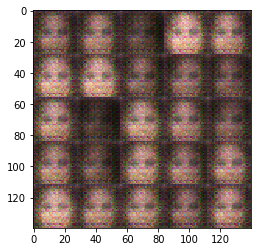

Epoch 1 of 3... Batch 210...  elapsed time - 57.85s  Discriminator Loss: 0.4852... Generator Loss: 1.6007
Epoch 1 of 3... Batch 240...  elapsed time - 65.81s  Discriminator Loss: 0.9917... Generator Loss: 0.5344
Epoch 1 of 3... Batch 270...  elapsed time - 73.76s  Discriminator Loss: 0.3914... Generator Loss: 2.3049
Epoch 1 of 3... Batch 300...  elapsed time - 81.72s  Discriminator Loss: 0.5594... Generator Loss: 1.3109


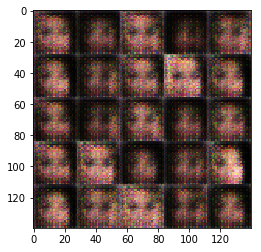

Epoch 1 of 3... Batch 330...  elapsed time - 90.54s  Discriminator Loss: 0.7316... Generator Loss: 1.4313
Epoch 1 of 3... Batch 360...  elapsed time - 98.52s  Discriminator Loss: 0.4501... Generator Loss: 2.0211
Epoch 1 of 3... Batch 390...  elapsed time - 106.49s  Discriminator Loss: 0.6071... Generator Loss: 3.4060


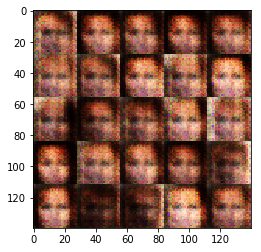

Epoch 1 of 3... Batch 420...  elapsed time - 115.33s  Discriminator Loss: 0.5679... Generator Loss: 1.7366
Epoch 1 of 3... Batch 450...  elapsed time - 123.28s  Discriminator Loss: 0.5939... Generator Loss: 1.6120
Epoch 1 of 3... Batch 480...  elapsed time - 131.24s  Discriminator Loss: 0.6747... Generator Loss: 2.1330


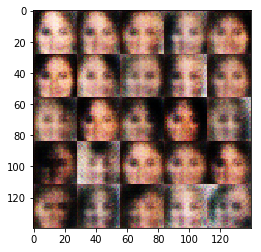

Epoch 1 of 3... Batch 510...  elapsed time - 140.05s  Discriminator Loss: 0.8359... Generator Loss: 1.0998
Epoch 1 of 3... Batch 540...  elapsed time - 147.97s  Discriminator Loss: 0.7989... Generator Loss: 1.3477
Epoch 1 of 3... Batch 570...  elapsed time - 155.90s  Discriminator Loss: 0.6864... Generator Loss: 1.5384
Epoch 1 of 3... Batch 600...  elapsed time - 163.83s  Discriminator Loss: 1.0468... Generator Loss: 0.9127


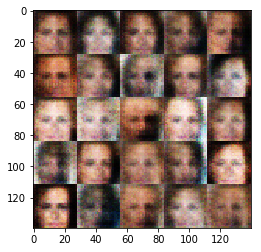

Epoch 1 of 3... Batch 630...  elapsed time - 172.66s  Discriminator Loss: 0.8287... Generator Loss: 1.3924
Epoch 1 of 3... Batch 660...  elapsed time - 180.62s  Discriminator Loss: 0.4901... Generator Loss: 1.5020
Epoch 1 of 3... Batch 690...  elapsed time - 188.63s  Discriminator Loss: 0.8121... Generator Loss: 1.2927


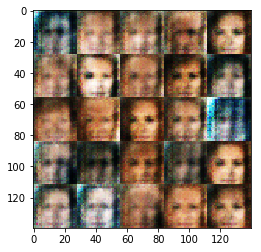

Epoch 1 of 3... Batch 720...  elapsed time - 197.48s  Discriminator Loss: 0.7989... Generator Loss: 1.4863
Epoch 1 of 3... Batch 750...  elapsed time - 205.43s  Discriminator Loss: 0.9524... Generator Loss: 1.3252
Epoch 1 of 3... Batch 780...  elapsed time - 213.42s  Discriminator Loss: 1.2639... Generator Loss: 0.7351


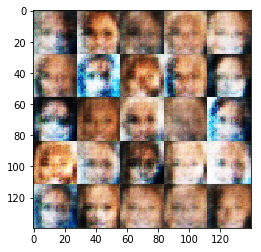

Epoch 1 of 3... Batch 810...  elapsed time - 222.23s  Discriminator Loss: 0.9532... Generator Loss: 1.1413
Epoch 1 of 3... Batch 840...  elapsed time - 230.18s  Discriminator Loss: 0.9050... Generator Loss: 1.5025
Epoch 1 of 3... Batch 870...  elapsed time - 238.15s  Discriminator Loss: 1.1661... Generator Loss: 0.7169
Epoch 1 of 3... Batch 900...  elapsed time - 246.13s  Discriminator Loss: 0.8501... Generator Loss: 1.2245


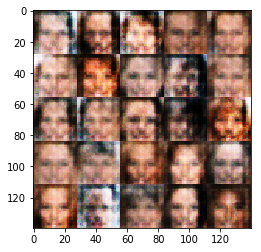

Epoch 1 of 3... Batch 930...  elapsed time - 254.94s  Discriminator Loss: 0.9399... Generator Loss: 1.2464
Epoch 1 of 3... Batch 960...  elapsed time - 262.92s  Discriminator Loss: 1.1132... Generator Loss: 1.1130
Epoch 1 of 3... Batch 990...  elapsed time - 270.87s  Discriminator Loss: 0.9601... Generator Loss: 0.9087


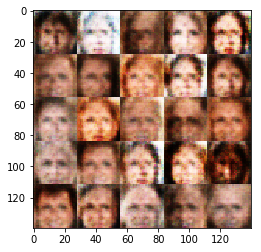

Epoch 1 of 3... Batch 1020...  elapsed time - 279.71s  Discriminator Loss: 1.0401... Generator Loss: 1.2223
Epoch 1 of 3... Batch 1050...  elapsed time - 287.69s  Discriminator Loss: 0.9181... Generator Loss: 1.2952
Epoch 1 of 3... Batch 1080...  elapsed time - 295.68s  Discriminator Loss: 1.1220... Generator Loss: 1.2541


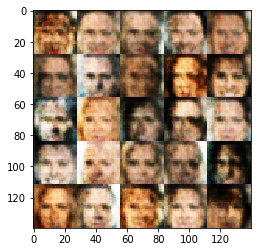

Epoch 1 of 3... Batch 1110...  elapsed time - 304.81s  Discriminator Loss: 1.1453... Generator Loss: 1.7901
Epoch 1 of 3... Batch 1140...  elapsed time - 312.79s  Discriminator Loss: 0.8444... Generator Loss: 1.1272
Epoch 1 of 3... Batch 1170...  elapsed time - 320.80s  Discriminator Loss: 1.1329... Generator Loss: 1.1382
Epoch 1 of 3... Batch 1200...  elapsed time - 328.81s  Discriminator Loss: 1.0872... Generator Loss: 0.8981


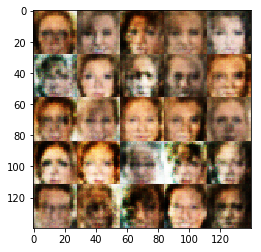

Epoch 1 of 3... Batch 1230...  elapsed time - 337.68s  Discriminator Loss: 0.8284... Generator Loss: 1.0731
Epoch 1 of 3... Batch 1260...  elapsed time - 345.64s  Discriminator Loss: 0.9998... Generator Loss: 1.0550
Epoch 1 of 3... Batch 1290...  elapsed time - 353.60s  Discriminator Loss: 0.9205... Generator Loss: 1.0423


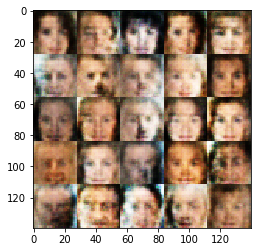

Epoch 1 of 3... Batch 1320...  elapsed time - 362.49s  Discriminator Loss: 1.1826... Generator Loss: 0.6405
Epoch 1 of 3... Batch 1350...  elapsed time - 370.54s  Discriminator Loss: 1.0358... Generator Loss: 1.4428
Epoch 1 of 3... Batch 1380...  elapsed time - 378.53s  Discriminator Loss: 0.9529... Generator Loss: 1.1656


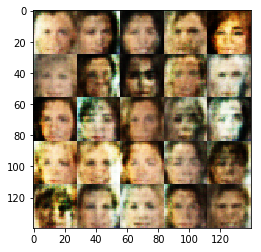

Epoch 1 of 3... Batch 1410...  elapsed time - 387.37s  Discriminator Loss: 1.0777... Generator Loss: 1.0196
Epoch 1 of 3... Batch 1440...  elapsed time - 395.30s  Discriminator Loss: 0.9649... Generator Loss: 1.1858
Epoch 1 of 3... Batch 1470...  elapsed time - 403.26s  Discriminator Loss: 0.9472... Generator Loss: 1.1941
Epoch 1 of 3... Batch 1500...  elapsed time - 411.23s  Discriminator Loss: 1.0134... Generator Loss: 0.8281


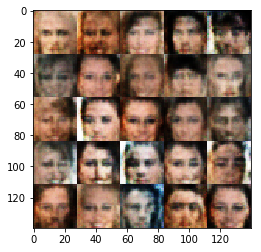

Epoch 1 of 3... Batch 1530...  elapsed time - 420.08s  Discriminator Loss: 1.2477... Generator Loss: 1.3889
Epoch 1 of 3... Batch 1560...  elapsed time - 428.05s  Discriminator Loss: 0.9524... Generator Loss: 1.2800
Epoch 2 of 3... Batch 30...  elapsed time - 441.74s  Discriminator Loss: 0.9556... Generator Loss: 0.8766
Epoch 2 of 3... Batch 60...  elapsed time - 449.87s  Discriminator Loss: 0.9131... Generator Loss: 0.9823
Epoch 2 of 3... Batch 90...  elapsed time - 458.13s  Discriminator Loss: 0.9528... Generator Loss: 1.1389


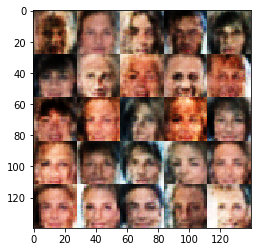

Epoch 2 of 3... Batch 120...  elapsed time - 467.03s  Discriminator Loss: 0.9296... Generator Loss: 1.0167
Epoch 2 of 3... Batch 150...  elapsed time - 475.01s  Discriminator Loss: 0.9929... Generator Loss: 0.8295
Epoch 2 of 3... Batch 180...  elapsed time - 482.95s  Discriminator Loss: 0.9344... Generator Loss: 1.1201


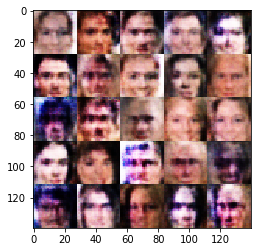

Epoch 2 of 3... Batch 210...  elapsed time - 491.76s  Discriminator Loss: 1.2190... Generator Loss: 0.8437
Epoch 2 of 3... Batch 240...  elapsed time - 499.72s  Discriminator Loss: 0.9094... Generator Loss: 1.5982
Epoch 2 of 3... Batch 270...  elapsed time - 507.68s  Discriminator Loss: 0.9316... Generator Loss: 1.0828
Epoch 2 of 3... Batch 300...  elapsed time - 515.71s  Discriminator Loss: 0.8880... Generator Loss: 1.2364


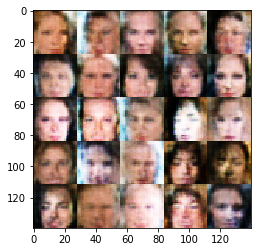

Epoch 2 of 3... Batch 330...  elapsed time - 524.56s  Discriminator Loss: 0.9296... Generator Loss: 0.8565
Epoch 2 of 3... Batch 360...  elapsed time - 532.57s  Discriminator Loss: 1.0827... Generator Loss: 1.2348
Epoch 2 of 3... Batch 390...  elapsed time - 540.57s  Discriminator Loss: 0.9230... Generator Loss: 1.2741


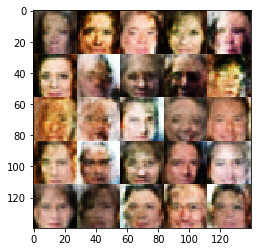

Epoch 2 of 3... Batch 420...  elapsed time - 549.71s  Discriminator Loss: 0.9890... Generator Loss: 1.2189
Epoch 2 of 3... Batch 450...  elapsed time - 557.66s  Discriminator Loss: 0.9688... Generator Loss: 1.0243
Epoch 2 of 3... Batch 480...  elapsed time - 565.64s  Discriminator Loss: 0.9423... Generator Loss: 0.8967


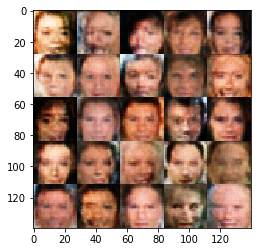

Epoch 2 of 3... Batch 510...  elapsed time - 574.51s  Discriminator Loss: 1.2095... Generator Loss: 0.6520
Epoch 2 of 3... Batch 540...  elapsed time - 582.48s  Discriminator Loss: 0.9804... Generator Loss: 0.9550
Epoch 2 of 3... Batch 570...  elapsed time - 590.37s  Discriminator Loss: 0.9215... Generator Loss: 1.0017
Epoch 2 of 3... Batch 600...  elapsed time - 598.36s  Discriminator Loss: 1.0088... Generator Loss: 1.0060


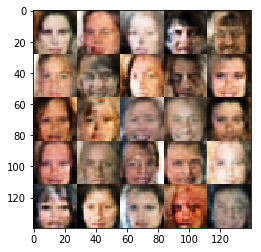

Epoch 2 of 3... Batch 630...  elapsed time - 607.22s  Discriminator Loss: 0.9402... Generator Loss: 0.9889
Epoch 2 of 3... Batch 660...  elapsed time - 615.20s  Discriminator Loss: 0.9243... Generator Loss: 1.1854
Epoch 2 of 3... Batch 690...  elapsed time - 623.18s  Discriminator Loss: 1.0611... Generator Loss: 1.2445


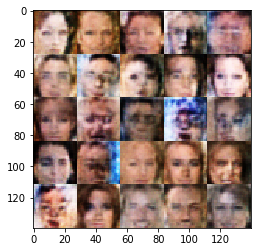

Epoch 2 of 3... Batch 720...  elapsed time - 632.09s  Discriminator Loss: 0.8998... Generator Loss: 1.0282
Epoch 2 of 3... Batch 750...  elapsed time - 640.04s  Discriminator Loss: 1.1404... Generator Loss: 1.1243
Epoch 2 of 3... Batch 780...  elapsed time - 648.05s  Discriminator Loss: 0.8746... Generator Loss: 1.2042


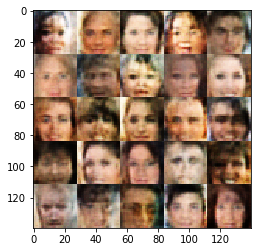

Epoch 2 of 3... Batch 810...  elapsed time - 656.96s  Discriminator Loss: 0.8478... Generator Loss: 0.9742
Epoch 2 of 3... Batch 840...  elapsed time - 664.94s  Discriminator Loss: 0.7829... Generator Loss: 1.3592
Epoch 2 of 3... Batch 870...  elapsed time - 672.92s  Discriminator Loss: 0.9459... Generator Loss: 1.2052
Epoch 2 of 3... Batch 900...  elapsed time - 680.93s  Discriminator Loss: 0.7874... Generator Loss: 1.5645


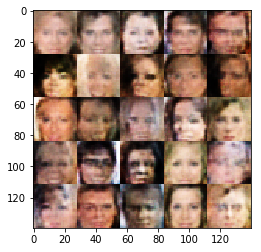

Epoch 2 of 3... Batch 930...  elapsed time - 689.82s  Discriminator Loss: 0.9823... Generator Loss: 0.9261
Epoch 2 of 3... Batch 960...  elapsed time - 697.85s  Discriminator Loss: 1.0620... Generator Loss: 1.6930
Epoch 2 of 3... Batch 990...  elapsed time - 705.85s  Discriminator Loss: 0.7439... Generator Loss: 1.2619


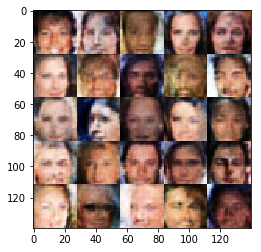

Epoch 2 of 3... Batch 1020...  elapsed time - 714.71s  Discriminator Loss: 0.7721... Generator Loss: 1.2446
Epoch 2 of 3... Batch 1050...  elapsed time - 722.70s  Discriminator Loss: 1.0925... Generator Loss: 0.6811
Epoch 2 of 3... Batch 1080...  elapsed time - 730.70s  Discriminator Loss: 0.9941... Generator Loss: 0.9397


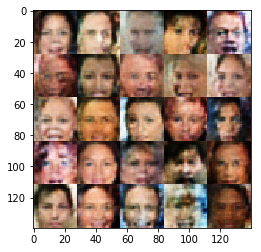

Epoch 2 of 3... Batch 1110...  elapsed time - 739.90s  Discriminator Loss: 1.2497... Generator Loss: 0.5100
Epoch 2 of 3... Batch 1140...  elapsed time - 747.90s  Discriminator Loss: 0.9365... Generator Loss: 1.5522
Epoch 2 of 3... Batch 1170...  elapsed time - 755.85s  Discriminator Loss: 1.0631... Generator Loss: 0.7572
Epoch 2 of 3... Batch 1200...  elapsed time - 763.78s  Discriminator Loss: 0.7891... Generator Loss: 1.0501


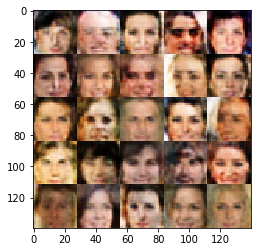

Epoch 2 of 3... Batch 1230...  elapsed time - 772.63s  Discriminator Loss: 0.9055... Generator Loss: 1.1624
Epoch 2 of 3... Batch 1260...  elapsed time - 780.63s  Discriminator Loss: 0.8847... Generator Loss: 1.2450
Epoch 2 of 3... Batch 1290...  elapsed time - 788.64s  Discriminator Loss: 0.6092... Generator Loss: 2.0825


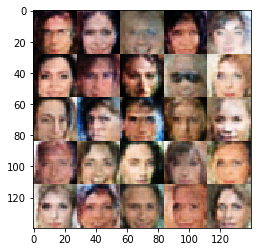

Epoch 2 of 3... Batch 1320...  elapsed time - 797.53s  Discriminator Loss: 0.9216... Generator Loss: 0.8551
Epoch 2 of 3... Batch 1350...  elapsed time - 805.52s  Discriminator Loss: 0.9330... Generator Loss: 1.1293
Epoch 2 of 3... Batch 1380...  elapsed time - 813.50s  Discriminator Loss: 0.9354... Generator Loss: 0.8718


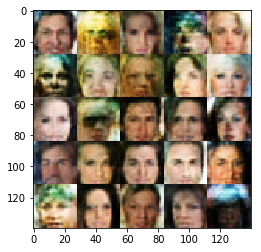

Epoch 2 of 3... Batch 1410...  elapsed time - 822.37s  Discriminator Loss: 0.8722... Generator Loss: 1.5413
Epoch 2 of 3... Batch 1440...  elapsed time - 830.36s  Discriminator Loss: 0.8810... Generator Loss: 1.0896
Epoch 2 of 3... Batch 1470...  elapsed time - 838.36s  Discriminator Loss: 0.8710... Generator Loss: 1.3776
Epoch 2 of 3... Batch 1500...  elapsed time - 846.35s  Discriminator Loss: 0.7710... Generator Loss: 1.1899


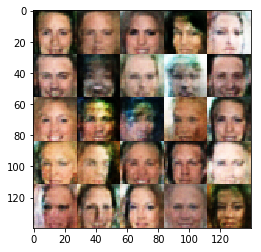

Epoch 2 of 3... Batch 1530...  elapsed time - 855.19s  Discriminator Loss: 0.8731... Generator Loss: 1.1582
Epoch 2 of 3... Batch 1560...  elapsed time - 863.16s  Discriminator Loss: 0.9845... Generator Loss: 2.0868
Epoch 3 of 3... Batch 30...  elapsed time - 876.88s  Discriminator Loss: 1.0532... Generator Loss: 1.1275
Epoch 3 of 3... Batch 60...  elapsed time - 884.84s  Discriminator Loss: 0.9696... Generator Loss: 0.8689
Epoch 3 of 3... Batch 90...  elapsed time - 892.82s  Discriminator Loss: 0.9952... Generator Loss: 1.0105


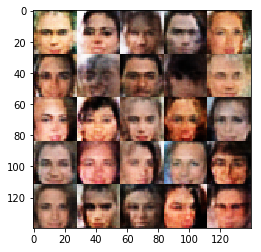

Epoch 3 of 3... Batch 120...  elapsed time - 901.75s  Discriminator Loss: 0.9429... Generator Loss: 0.9049
Epoch 3 of 3... Batch 150...  elapsed time - 909.77s  Discriminator Loss: 0.8838... Generator Loss: 1.0164
Epoch 3 of 3... Batch 180...  elapsed time - 917.79s  Discriminator Loss: 0.7971... Generator Loss: 1.2936


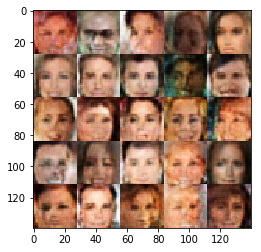

Epoch 3 of 3... Batch 210...  elapsed time - 926.70s  Discriminator Loss: 1.0281... Generator Loss: 0.7428
Epoch 3 of 3... Batch 240...  elapsed time - 934.68s  Discriminator Loss: 1.0003... Generator Loss: 0.9357
Epoch 3 of 3... Batch 270...  elapsed time - 942.65s  Discriminator Loss: 1.0798... Generator Loss: 0.9592
Epoch 3 of 3... Batch 300...  elapsed time - 950.65s  Discriminator Loss: 0.9617... Generator Loss: 0.8542


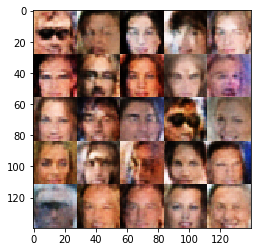

Epoch 3 of 3... Batch 330...  elapsed time - 959.52s  Discriminator Loss: 0.6802... Generator Loss: 1.4232
Epoch 3 of 3... Batch 360...  elapsed time - 967.49s  Discriminator Loss: 0.9691... Generator Loss: 1.0252
Epoch 3 of 3... Batch 390...  elapsed time - 975.47s  Discriminator Loss: 0.9927... Generator Loss: 1.3496


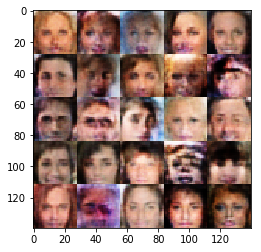

Epoch 3 of 3... Batch 420...  elapsed time - 984.30s  Discriminator Loss: 0.7652... Generator Loss: 1.4752
Epoch 3 of 3... Batch 450...  elapsed time - 992.31s  Discriminator Loss: 0.9489... Generator Loss: 0.8973
Epoch 3 of 3... Batch 480...  elapsed time - 1000.30s  Discriminator Loss: 0.9929... Generator Loss: 0.9172


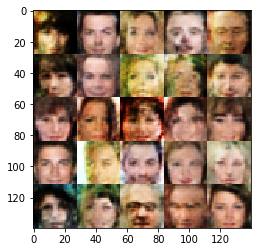

Epoch 3 of 3... Batch 510...  elapsed time - 1009.20s  Discriminator Loss: 1.0423... Generator Loss: 0.9593
Epoch 3 of 3... Batch 540...  elapsed time - 1017.16s  Discriminator Loss: 0.9795... Generator Loss: 1.2299
Epoch 3 of 3... Batch 570...  elapsed time - 1025.14s  Discriminator Loss: 0.9714... Generator Loss: 1.0432
Epoch 3 of 3... Batch 600...  elapsed time - 1033.13s  Discriminator Loss: 0.9698... Generator Loss: 0.8704


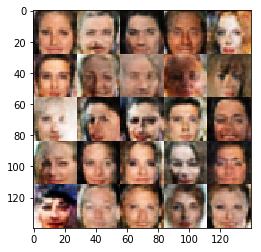

Epoch 3 of 3... Batch 630...  elapsed time - 1042.03s  Discriminator Loss: 0.8670... Generator Loss: 1.1679
Epoch 3 of 3... Batch 660...  elapsed time - 1050.02s  Discriminator Loss: 0.8734... Generator Loss: 1.3203
Epoch 3 of 3... Batch 690...  elapsed time - 1058.04s  Discriminator Loss: 0.9923... Generator Loss: 1.0954


In [ ]:
batch_size = 128
z_dim = 50
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.